In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE


# Settings:
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2
feature = [i for i in range(1,15)]


try:
    X = np.load('X.npy')
    Y = np.load('Y.npy')
except:
    labels = listdir(dataset_path) # Geting labels
    X = []
    Y = []
    for i, label in enumerate(labels):
        datas_path = dataset_path+'/'+label
        for data in listdir(datas_path):
            img = get_img(datas_path+'/'+data)
            X.append(img)
            Y.append(i)
    X = 1-np.array(X).astype('float32')/255.
    Y = np.array(Y).astype('float32')
    Y = to_categorical(Y, num_class)
    np.save('X.npy', X)
    np.save('Y.npy', Y)

y=np.zeros((2062,))

for i in range(2062):
    for j in range(10):
        y[i]+=Y[i, j]*j

X = X.reshape((X.shape[0], -1))

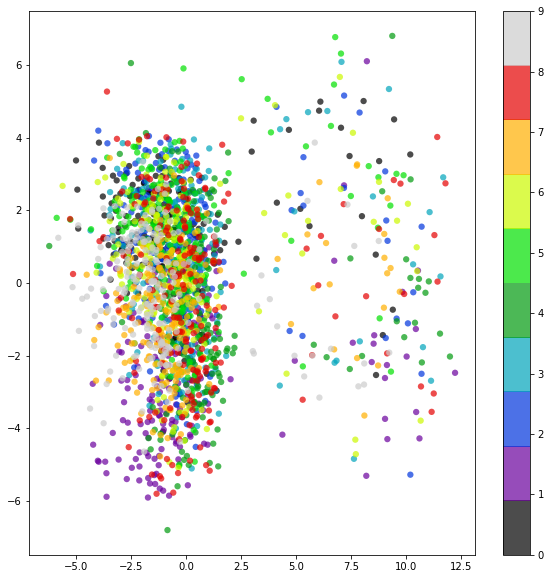

In [2]:
pca = decomposition.PCA(n_components=2, random_state=7)
X_pca_2 = pca.fit_transform(X)

plt.figure(figsize=(10, 10))
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

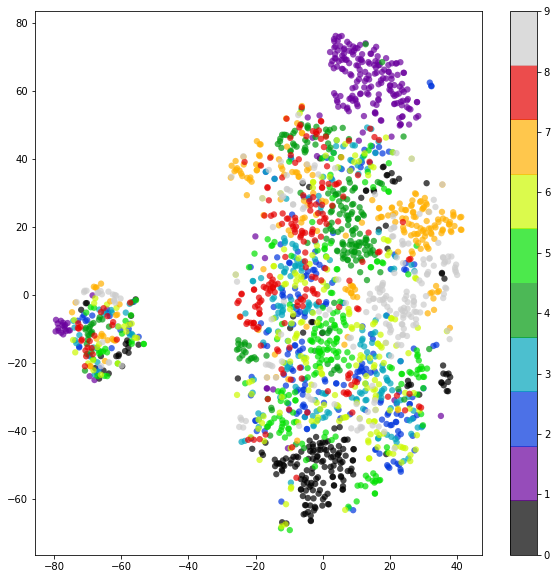

In [3]:
tsne = TSNE(random_state=7)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y,edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

In [4]:
pca = decomposition.PCA(n_components=178, random_state=7)
X_pca = pca.fit_transform(X)

print(np.sum(pca.explained_variance_ratio_))

0.9005779


In [5]:
algo = KMeans(n_clusters=10, random_state=None)

data = []
algo.fit(X)
data.append(({
    'ARI': metrics.adjusted_rand_score(y, algo.labels_),
    'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_, average_method='arithmetic'),
    'Homogenity': metrics.homogeneity_score(y, algo.labels_),
    'Completeness': metrics.completeness_score(y, algo.labels_),
    'V-measure': metrics.v_measure_score(y, algo.labels_),
    'Silhouette': metrics.silhouette_score(X, algo.labels_)
}))

algo.fit(X_pca)
data.append(({
    'ARI': metrics.adjusted_rand_score(y, algo.labels_),
    'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_, average_method='arithmetic'),
    'Homogenity': metrics.homogeneity_score(y, algo.labels_),
    'Completeness': metrics.completeness_score(y, algo.labels_),
    'V-measure': metrics.v_measure_score(y, algo.labels_),
    'Silhouette': metrics.silhouette_score(X, algo.labels_)
}))

results = pd.DataFrame(
    data=data,
    columns=['ARI', 'AMI', 'Homogenity', 'Completeness', 'V-measure', 'Silhouette'],
    index=['K-means', 'K-means_PCA']
)

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.130756,0.197092,0.201464,0.206841,0.204117,0.033472
K-meansPCA,0.108650,0.175368,0.179975,0.185285,0.182592,0.036846


Лучший результат показывает метрика полноты, однако другие метрики использующие функции энтропии отстают не сильно. Всё ещё по всем метрикам результаты плохие из-за выбросов и сгущённости данных. Сжатые данные кластеризируются чуть лучше.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [7]:
model = KMeans(n_clusters=10)
model.fit(X_train,  Y_train)
Y_pred = model.predict(X_test)
print(f"K-means accuracy is {accuracy_score(np.around(Y_test), Y_pred)}")

model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(f"LinearRegression is {accuracy_score(np.around(Y_test), np.around(Y_pred))}")

K-means accuracy is 0.07990314769975787
LinearRegression is 0.08958837772397095


Аккуратность Линейной регрессии составляет 0.09, что даже меньше, чем если определять случайно. Для K-means результаты разняться от 0.04 до 0.15, в зависимости от случайности. В целом для данного необработанного датасета кластеризация не имеет смысла.